In [2]:
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure

import glob

from datetime import datetime
from datetime import datetime, timedelta

import statsmodels.api as sm

from IPython.display import display, Markdown

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Loading & pre-processing

In [3]:
def read_file_to_df(path):
    all_files = glob.glob(path + '/*.csv')
    df = pd.DataFrame()
    for filename in all_files:
        temp = pd.read_csv(filename)
        df = pd.concat([df, temp])
    return df

In [4]:
def fix_data(data, name_of_pump):
    data = data[['datumBeginMeting', 'datumEindeMeting', 'hstWaarde']]
    data = data.rename(columns = {'hstWaarde' : '{}'.format(name_of_pump)})
    data['datetime'] = pd.to_datetime(data['datumBeginMeting'], format = '%Y-%m-%d %H:%M:%S')
    data['datumBeginMeting'] = pd.to_datetime(data['datumBeginMeting'], format='%Y-%m-%d %H:%M:%S')
    data['datumEindeMeting'] = pd.to_datetime(data['datumEindeMeting'], format='%Y-%m-%d %H:%M:%S')
    data = data.set_index('datumBeginMeting')
    data = data.sort_index() # Datetime index
    return data

In [5]:
def first_non_zero(data, name):
    s = pd.Series(data[name])
    f = pd.DataFrame(s.iloc[s.nonzero()[0]]).reset_index()

    m_index = f['datumBeginMeting'][0]
    print(m_index)
    data3 = data.loc[m_index:,:]
    data3[name].plot()
    return data3

In [6]:
def only_changed_rows(df, give_index=False, silent=False):
    changed_elements_index = df.shift() != df
    
    if not silent: # Print amount of changed rows message:
        total = df.shape[0]
        remaining = changed_elements_index.any(axis=1).sum()
        display(Markdown(f"Of **{total:,}** rows, **{total-remaining:,} ({(total-remaining)/total:.2%})**\
        were found to be consecutive duplicates. \n**{remaining:,}** rows remaining."))
    
    return changed_elements_index if give_index else df.loc[changed_elements_index.any(axis=1)]

In [7]:
def timeGrouper(data, name):
    return data.groupby(pd.TimeGrouper('H'))[name].mean()

In [8]:
def dry_df(df):
    df = pd.read_csv(df, sep="\n", header=None)
    df.columns = ["a"]
    df['datetime'] = pd.to_datetime(df['a'], format = '%Y-%m-%d %H:%M:%S')
    df = df[['datetime']]
    return df

In [9]:
def whole_df(df):
    df = pd.read_csv('./data/den bosch/whole map/' + df + '.csv', sep="," or "\n")
    df = df.iloc[:,1:3].rename(columns = {'Begin':'Datetime', df.columns[2]:'Rain'})
    
    df = df.set_index(pd.to_datetime(df['Datetime'], format = '%Y-%m-%d %H:%M:%S'))
    df['Rain'] = df['Rain'] * 10000
    df = df.groupby(pd.TimeGrouper('H'))['Rain'].sum()

#     df['datetime'] = pd.to_datetime(df['a'], format = '%Y-%m-%d %H:%M:%S')
#     df = df.set_index(df['datetime'])
    return df

In [10]:
def filterDryDays(data, dry, name_of_pump):
    data = pd.DataFrame(data)
    dry = np.where(data.index.isin(dry['datetime']), 1, 0)
    data['dry'] = dry
    return data
    #data = data[data['dry'] == 1]
    #data['interaction'] = data[name_of_pump] * data['dry']#.groupby([de_rompert.index.year, de_rompert.index.month, de_rompert.index.day, de_rompert.index.hour]).mean()

In [11]:
def interpolate(data1, name):
    a = data1[data1['dry'] == 1]
    b = data1[data1['dry'] == 0]
    b[name] = np.NAN
    data1 = a.append(b).sort_index()
    data2 = data1[name].interpolate(method = 'time')
    data2 =  pd.DataFrame(data2)
    return data2

In [12]:
def create_dummies(data, y):
    data['1'] = np.where(data.index.hour == 0, 1, 0)
    data['2'] = np.where(data.index.hour == 1, 1, 0)
    data['3'] = np.where(data.index.hour == 2, 1, 0)
    data['4'] = np.where(data.index.hour == 3, 1, 0)
    data['5'] = np.where(data.index.hour == 4, 1, 0)
    data['6'] = np.where(data.index.hour == 5, 1, 0)
    data['7'] = np.where(data.index.hour == 6, 1, 0)
    data['8'] = np.where(data.index.hour == 7, 1, 0)
    data['9'] = np.where(data.index.hour == 8, 1, 0)
    data['10'] = np.where(data.index.hour == 9, 1, 0)
    data['11'] = np.where(data.index.hour == 10, 1, 0)
    data['12'] = np.where(data.index.hour == 11, 1, 0)
    data['13'] = np.where(data.index.hour == 12, 1, 0)
    data['14'] = np.where(data.index.hour == 13, 1, 0)
    data['15'] = np.where(data.index.hour == 14, 1, 0)
    data['16'] = np.where(data.index.hour == 15, 1, 0)
    data['17'] = np.where(data.index.hour == 16, 1, 0)
    data['18'] = np.where(data.index.hour == 17, 1, 0)
    data['19'] = np.where(data.index.hour == 18, 1, 0)
    data['20'] = np.where(data.index.hour == 19, 1, 0)
    data['21'] = np.where(data.index.hour == 20, 1, 0)
    data['22'] = np.where(data.index.hour == 21, 1, 0)
    data['23'] = np.where(data.index.hour == 22, 1, 0)
    
    data['monday'] = np.where(data.index.day == 0, 1, 0)
    data['tuesday'] = np.where(data.index.day == 1, 1, 0)
    data['wednesday'] = np.where(data.index.day == 2, 1, 0)
    data['thursday'] = np.where(data.index.day == 3, 1, 0)
    data['friday'] = np.where(data.index.day == 4, 1, 0)
    data['saturday'] = np.where(data.index.day == 5, 1, 0)
    
    data['january'] = np.where(data.index.month == 1, 1, 0)
    data['february'] = np.where(data.index.month == 2, 1, 0)
    data['march'] = np.where(data.index.month == 3, 1, 0)
    data['april'] = np.where(data.index.month == 4, 1, 0)
    data['may'] = np.where(data.index.month == 5, 1, 0)
    data['june'] = np.where(data.index.month == 6, 1, 0)
    data['july'] = np.where(data.index.month == 7, 1, 0)
    data['august'] = np.where(data.index.month == 8, 1, 0)
    data['september'] = np.where(data.index.month == 9, 1, 0)
    data['october'] = np.where(data.index.month == 10, 1, 0)
    data['november'] = np.where(data.index.month == 11, 1, 0)
    
    data['1hour'] = data[y].shift(-1)
    data['2hours'] = data[y].shift(-2)
    data['3hours'] = data[y].shift(-3)
    
    return data

In [179]:
def complete_preprocess_for_model(path, name, dry_filename, whole_df_name):
    data = read_file_to_df(path)
    data = fix_data(data, name)
    data = first_non_zero(data, name)
    data = only_changed_rows(data)
    data = timeGrouper(data, name)
    dry = dry_df(dry_filename)
    whole = whole_df(whole_df_name)
    data = filterDryDays(data, dry, name)
    data = interpolate(data, name)
    data = create_dummies(data, name).dropna()
    #data_model = RF_model(data, name)
    return data, dry, whole # do not forget data_model

In [197]:
def RF_model(data, name):
    X = (data.drop([name], axis = 1))
    y = (data[name])
    
    X_train = pd.DataFrame(X.iloc[:10775,:])
    y_train = pd.DataFrame(y.iloc[:10775])
    y_predicted = pd.Series()
    y_real = y[10775:]
    
    n_train = 10775
    n_records = len(X)
    print('Starting point: ', n_train)
    print('Finish: ', n_records)
    
    for i in range(n_train, n_records - 1):
        X_train, X_test = X.iloc[0:i,:] , X.iloc[i:i + 24,:]
        y_train, y_test = y.iloc[0:i], y.iloc[i: i + 24]
        if i % 10 == 0:
            print(i)
        
        RF_Model = RandomForestRegressor(n_estimators=50, random_state = 42, oob_score=True, max_depth = 6)
        
        rgr = RF_Model.fit(X_train, y_train)
        tempeh = pd.DataFrame(rgr.predict(X_test)).T
        tempeh['time'] = X.iloc[i - 1,:].name
        tempeh = tempeh.set_index(tempeh['time']).drop('time', axis = 1)
        y_predicted = y_predicted.append(tempeh)
     
    for j in range(1,25):
        y_predicted = y_predicted.rename(columns = {j - 1:timedelta(hours=j)})         
#    validation = pd.DataFrame(index = y_real.index)
#    validation['Real flow (m^3/h)'] = y_real
#    validation['Prediction Flow (m^3/h)'] = y_predicted
    
    return y_real, y_predicted

In [226]:
de_rompert_real, de_rompert_pred = RF_model(original_rompert, 'de_rompert')

Starting point:  10775
Finish:  10821
10780
10790
10800
10810


In [247]:
def shiftModelData(predictions, real):
    shifted_pred = predictions.copy()
    for i in range(len(predictions.columns)):
        shifted_pred.iloc[:,i] = predictions.iloc[:,i].shift(i)
        shifted_pred = shifted_pred.rename(columns = {shifted_pred.columns[i]:'Prediction {}'.format(i + 1)})
    shifted_pred = pd.DataFrame(real).join(shifted_pred, how = 'outer')
    return shifted_pred
rompert_valid = shiftModelData(de_rompert_pred, de_rompert_real)

In [269]:
rompert_error = pd.DataFrame()
for i in range(1, len(rompert_valid.columns)):
    rompert_error[i] = rompert_valid.iloc[:,i] - rompert_valid['de_rompert']

In [284]:
rompert_error.mean(axis = 0)

1     24.082275
2     23.953237
3     25.977646
4     25.329330
5     25.381701
6     26.035272
7     26.447782
8     26.143486
9     25.203106
10    24.292098
11    20.201691
12    17.403285
13    17.001638
14    14.725499
15    14.384556
16    18.435098
17    19.899291
18    20.485637
19    21.064237
20    21.977033
21    21.719872
22    21.579302
23    19.806514
24    22.074947
dtype: float64

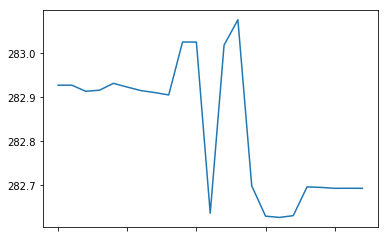

In [258]:
rompert_valid.loc['2019-07-29 20:00:00','Prediction 1':].plot()


2018-01-01 00:00:00


Of **863,880** rows, **40 (0.00%)**        were found to be consecutive duplicates. 
**863,840** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


Starting point:  14206
Finish:  14349
[405.32744438 405.32744438 405.32744438 405.32744438 405.32744438
 405.32744438 405.32744438 405.32744438 372.16186054 403.85119894
 405.32744438 405.32744438 405.32744438 405.32744438 405.32744438
 405.32744438 405.32744438 405.32744438 405.32744438 405.32744438
 405.32744438 405.32744438 405.32744438]
[405.33114383 405.33114383 405.33114383 405.33114383 405.33114383
 405.33114383 405.33114383 372.1664017  403.85506748 405.33114383
 405.33114383 405.33114383 405.33114383 405.33114383 405.33114383
 405.33114383 405.33114383 405.33114383 405.33114383 405.33114383
 405.33114383 405.33114383 405.33114383]
[405.33038155 405.33038155 405.33038155 405.33038155 405.33038155
 405.33038155 372.16713332 403.8543052  405.33038155 405.33038155
 405.33038155 405.33038155 405.33038155 405.33038155 405.33038155
 405.33038155 405.33038155 405.33038155 405.33038155 405.33038155
 405.33038155 405.33038155 405.33038155]
[405.33215901 405.33215901 405.33215901 405.332

[405.1663244  405.1663244  405.1663244  405.1663244  405.1663244
 372.3616044  403.69785532 405.1663244  405.1663244  405.1663244
 405.1663244  405.1663244  405.1663244  405.1663244  405.1663244
 405.1663244  405.1663244  405.1663244  405.1663244  405.1663244
 405.1663244  405.1663244  405.1663244 ]
[405.16563559 405.16563559 405.16563559 405.16563559 372.3619563
 403.69716651 405.16563559 405.16563559 405.16563559 405.16563559
 405.16563559 405.16563559 405.16563559 405.16563559 405.16563559
 405.16563559 405.16563559 405.16563559 405.16563559 405.16563559
 405.16563559 405.16563559 405.16563559]
[405.16645963 405.16645963 405.16645963 372.36307426 403.69815734
 405.16645963 405.16645963 405.16645963 405.16645963 405.16645963
 405.16645963 405.16645963 405.16645963 405.16645963 405.16645963
 405.16645963 405.16645963 405.16645963 405.16645963 405.16645963
 405.16645963 405.16645963 405.16645963]
[405.16503877 405.16503877 372.36451924 403.69673648 405.16503877
 405.16503877 405.165038

[404.74785924 404.74785924 374.15111007 403.28137964 404.74785924
 404.74785924 404.74785924 404.74785924 404.74785924 404.74785924
 404.74785924 404.74785924 404.74785924 404.74785924 404.74785924
 404.74785924 404.74785924 404.74785924 404.74785924 404.74785924
 404.74785924 404.74785924 404.74785924]
[404.74999706 374.15311614 403.28359979 404.74999706 404.74999706
 404.74999706 404.74999706 404.74999706 404.74999706 404.74999706
 404.74999706 404.74999706 404.74999706 404.74999706 404.74999706
 404.74999706 404.74999706 404.74999706 404.74999706 404.74999706
 404.74999706 404.74999706 404.74999706]
[374.15371867 403.28302523 404.74942249 404.74942249 404.74942249
 404.74942249 404.74942249 404.74942249 404.74942249 404.74942249
 404.74942249 404.74942249 404.74942249 404.74942249 404.74942249
 404.74942249 404.74942249 404.74942249 404.74942249 404.74942249
 404.74942249 404.74942249 404.74942249]
[403.28487651 404.75127377 404.75127377 404.75127377 404.75127377
 404.75127377 404.7

[403.31268238 404.77146755 404.77146755 404.77146755 404.77146755
 404.77146755 404.77146755 404.77146755 404.77146755 404.77146755
 404.77146755 404.77146755 404.77146755 404.77146755 404.77146755
 404.77146755 404.77146755 404.77146755 404.77146755 404.77146755
 404.77146755 404.77146755 404.77146755]
[404.77100565 404.77100565 404.77100565 404.77100565 404.77100565
 404.77100565 404.77100565 404.77100565 404.77100565 404.77100565
 404.77100565 404.77100565 404.77100565 404.77100565 404.77100565
 404.77100565 404.77100565 404.77100565 404.77100565 404.77100565
 404.77100565 404.77100565 374.74378396]
[404.77336279 404.77336279 404.77336279 404.77336279 404.77336279
 404.77336279 404.77336279 404.77336279 404.77336279 404.77336279
 404.77336279 404.77336279 404.77336279 404.77336279 404.77336279
 404.77336279 404.77336279 404.77336279 404.77336279 404.77336279
 404.77336279 374.74687225 403.32022599]
[404.77238263 404.77238263 404.77238263 404.77238263 404.77238263
 404.77238263 404.7

[404.71229423 404.71229423 404.71229423 404.71229423 404.71229423
 404.71229423 404.71229423 404.71229423 404.71229423 404.71229423
 404.71229423 404.71229423 404.71229423 404.71229423 404.71229423
 404.71229423 404.71229423 404.71229423 404.71229423 404.71229423
 374.91174738 403.26690808 404.71229423]
[404.71193835 404.71193835 404.71193835 404.71193835 404.71193835
 404.71193835 404.71193835 404.71193835 404.71193835 404.71193835
 404.71193835 404.71193835 404.71193835 404.71193835 404.71193835
 404.71193835 404.71193835 404.71193835 404.71193835 374.9118372
 403.2665522  404.71193835 404.71193835]
[404.71433569 404.71433569 404.71433569 404.71433569 404.71433569
 404.71433569 404.71433569 404.71433569 404.71433569 404.71433569
 404.71433569 404.71433569 404.71433569 404.71433569 404.71433569
 404.71433569 404.71433569 404.71433569 374.91388249 403.26894953
 404.71433569 404.71433569 404.71433569]
[404.71605947 404.71605947 404.71605947 404.71605947 404.71605947
 404.71605947 404.71

KeyboardInterrupt: 

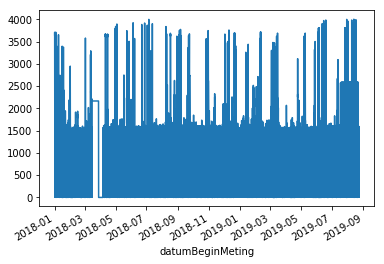

In [24]:
original_haarsteeg, haarsteeg, dry_haarsteeg, whole_haarsteeg = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/Haarsteeg/', 'haarsteeg', 'dry_haarsteeg', 'whole_haarsteeg')

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


2018-04-19 10:40:00


Of **673,220** rows, **20 (0.00%)**        were found to be consecutive duplicates. 
**673,200** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


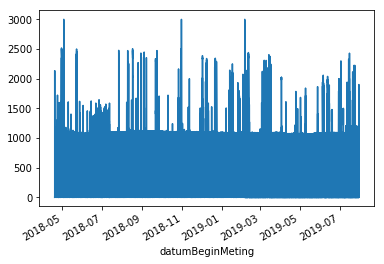

In [180]:
original_rompert, dry_rompert, whole_rompert = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/de Rompert/', 'de_rompert', 'dry_rompert', 'whole_rompert')

2018-01-01 00:00:00


Of **863,880** rows, **60 (0.01%)**        were found to be consecutive duplicates. 
**863,820** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


Starting point:  11479
Finish:  14349
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300


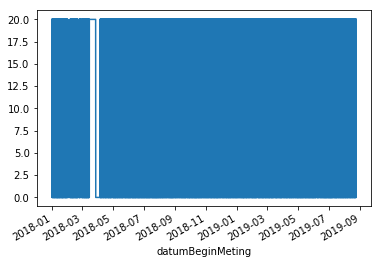

In [15]:
original_bokhoven, bokhoven, dry_bokhoven, whole_bokhoven = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/Bokhoven/', 'de_bokhoven', 'dry_bokhoven', 'whole_bokhoven')

2018-01-01 00:00:00


Of **863,880** rows, **41 (0.00%)**        were found to be consecutive duplicates. 
**863,839** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


Starting point:  11479
Finish:  14349
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300


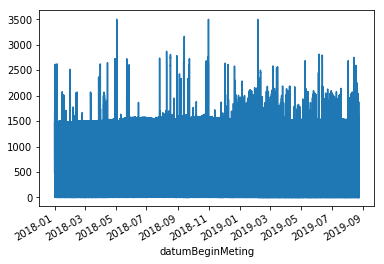

In [17]:
original_helftheuvelweg, helftheuvelweg, dry_helftheuvelweg, whole_helftheuvelweg = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/Helftheuvelweg/', 'helftheuvelweg', 'dry_helftheuvelweg', 'whole_helftheuvelweg')

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


2018-04-19 10:40:00


Of **673,220** rows, **20 (0.00%)**        were found to be consecutive duplicates. 
**673,200** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


Starting point:  8657
Finish:  10821
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800


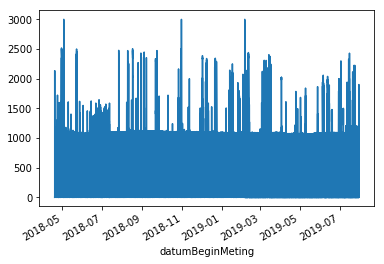

In [18]:
original_maaspoort, maaspoort, dry_maaspoort, whole_maaspoort = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/Maaspoort/', 'maaspoort', 'dry_maaspoort', 'whole_maaspoort')

2018-04-17 13:13:00


Of **710,507** rows, **0 (0.00%)**        were found to be consecutive duplicates. 
**710,507** rows remaining.

C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\s162378\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  import sys


Starting point:  9118
Finish:  11397
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300


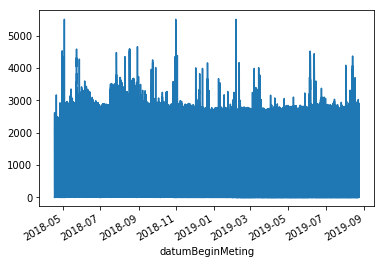

In [19]:
original_oudengelseweg, oudengelseweg, dry_oudengelseweg, whole_oudengelseweg = complete_preprocess_for_model('./data/den bosch/sewer_data_db/flow/Oud Engelseweg/', 'oudengelseweg', 'dry_oudengelseweg', 'whole_oudengelseweg')

### Dry weather model training

### Validation

In [16]:
def visualize(validation, name):
    ax = validation.plot(figsize=(15,8))
    ax.set_title('Flow prediction random forest ' + name, size = 20)
    ax.set_xlabel('Date', size = 15)
    ax.legend(prop={'size': 15})
    #['2019-05-03':'2019-05-05']
def mse(validation): 
    return np.sqrt(mean_squared_error(validation['Real flow (m^3/h)'], validation['Prediction Flow (m^3/h)']))
    
def visualize_mse(validation, name):
    validation['Error (m^3)/h'] = (validation['Real flow (m^3/h)'] - validation['Prediction Flow (m^3/h)'])
    ax2 = validation['Error (m^3)/h'].plot(figsize = (15,8))
    ax2.set_title('Flow prediction random forest ' + name, size = 20)
    ax2.set_xlabel('Date', size = 15)
    ax2.legend(prop={'size': 15})

def mae(validation):
    return mean_absolute_error(validation['Real flow (m^3/h)'], validation['Prediction Flow (m^3/h)'])

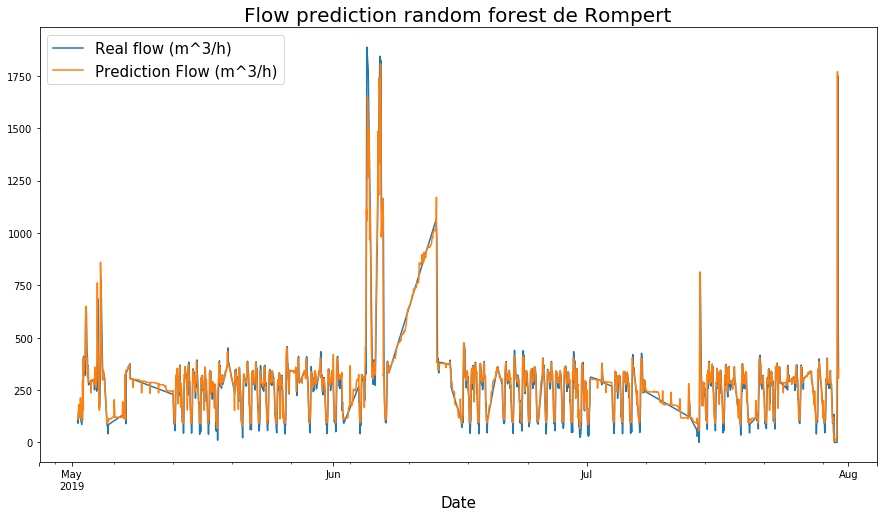

In [22]:
visualize(de_rompert, 'de Rompert')



In [17]:
visualize_mse(de_rompert, 'Rompert')
#whole_rompert['2019-05-03 16:00:00' : '2019-07-30 20:00:00'].plot()

NameError: name 'de_rompert' is not defined

In [24]:
mse(de_rompert)

74.99427991264228

In [26]:
de_rompert['Real flow (m^3/h)'].mean()

292.1297115680837

In [27]:
mae(de_rompert)

34.914066045164944

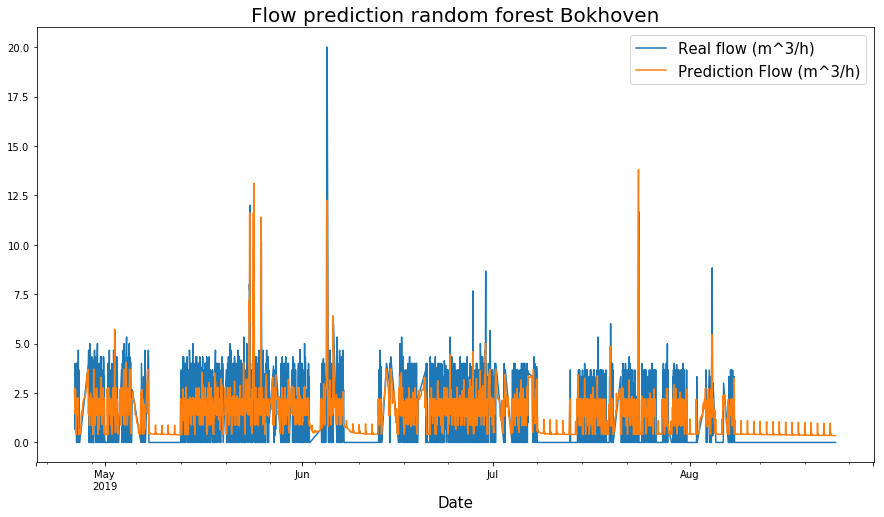

In [28]:
visualize(bokhoven, 'Bokhoven')

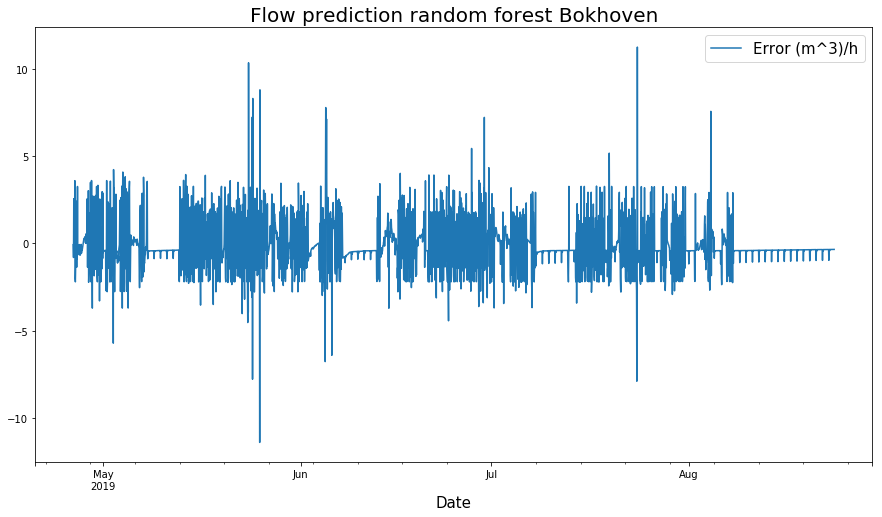

In [29]:
visualize_mse(bokhoven, 'Bokhoven')

In [30]:
mse(bokhoven)

1.5112859765527946

In [31]:
mae(bokhoven)

1.1159861506799067

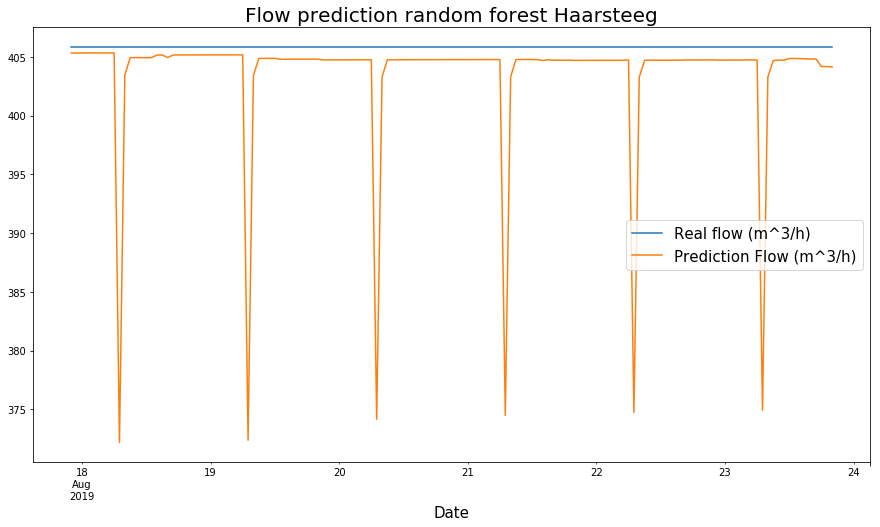

In [18]:
visualize(haarsteeg, 'Haarsteeg')

In [176]:
visualize_mse(haarsteeg, 'Haarsteeg')

KeyError: 'Real flow (m^3/h)'

In [20]:
mse(haarsteeg)

6.655393660836484

In [21]:
mae(haarsteeg)

2.3579980798040348

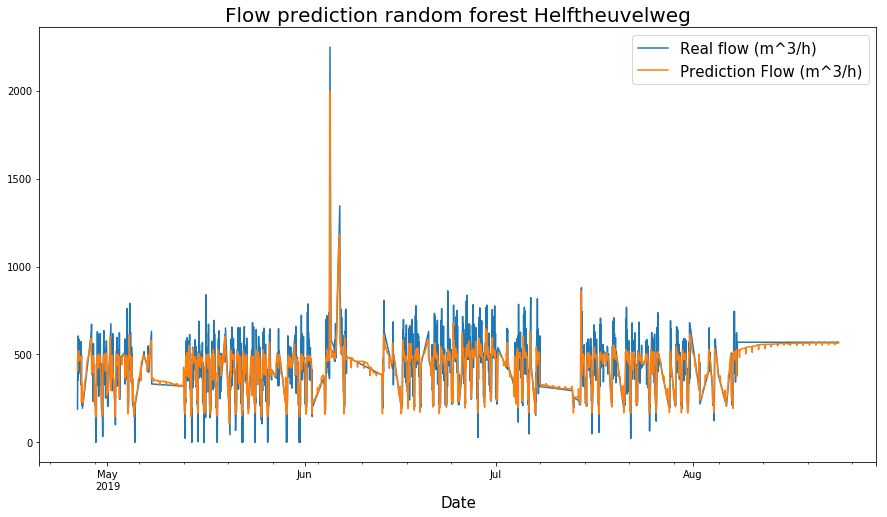

In [37]:
visualize(helftheuvelweg, 'Helftheuvelweg')

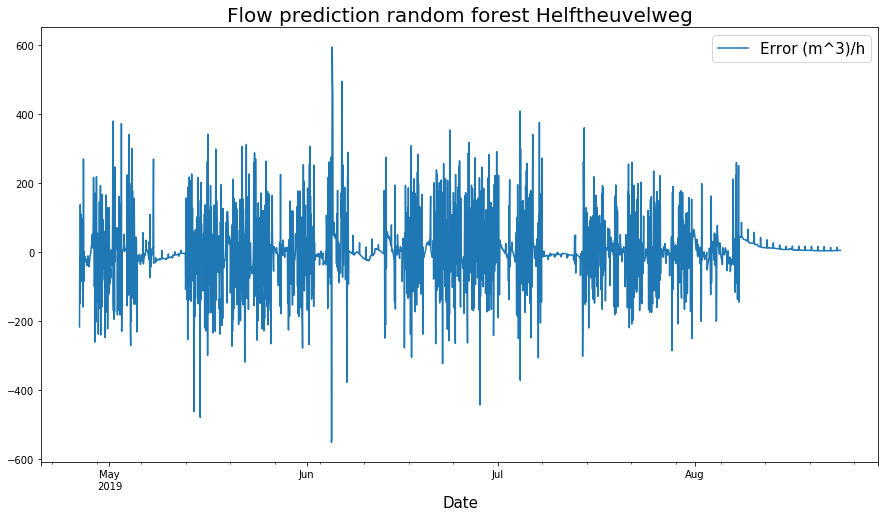

In [38]:
visualize_mse(helftheuvelweg, 'Helftheuvelweg')

In [39]:
mse(helftheuvelweg)

92.68446733165241

In [40]:
mae(helftheuvelweg)

57.02313246946115

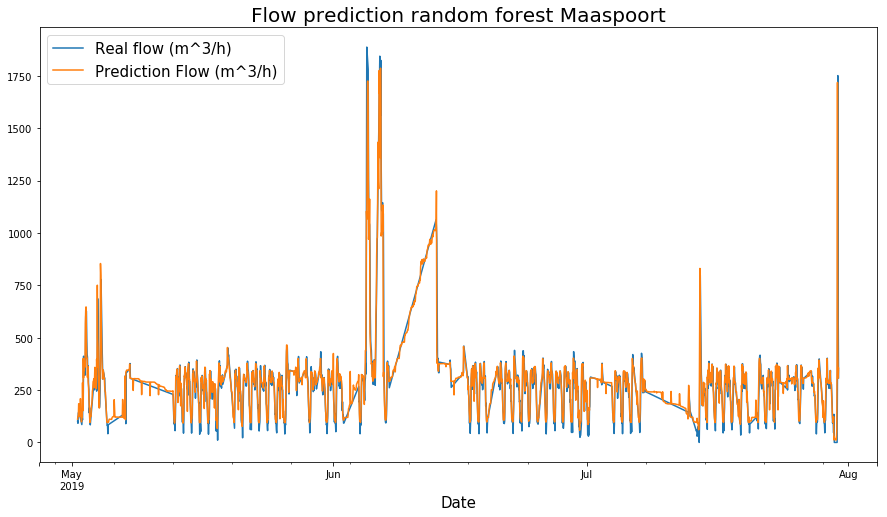

In [41]:
visualize(maaspoort, 'Maaspoort')

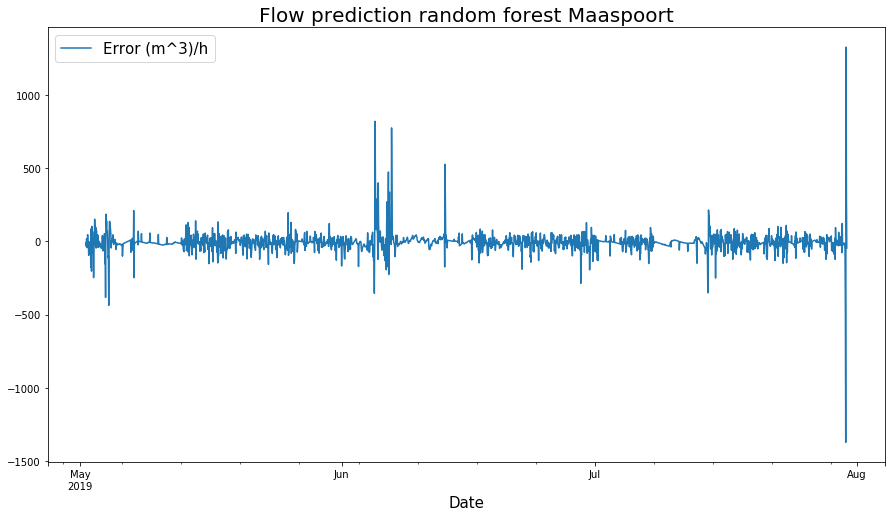

In [42]:
visualize_mse(maaspoort, 'Maaspoort')

In [43]:
mse(maaspoort)

73.2395335021618

In [44]:
mae(maaspoort)

34.27575852569811

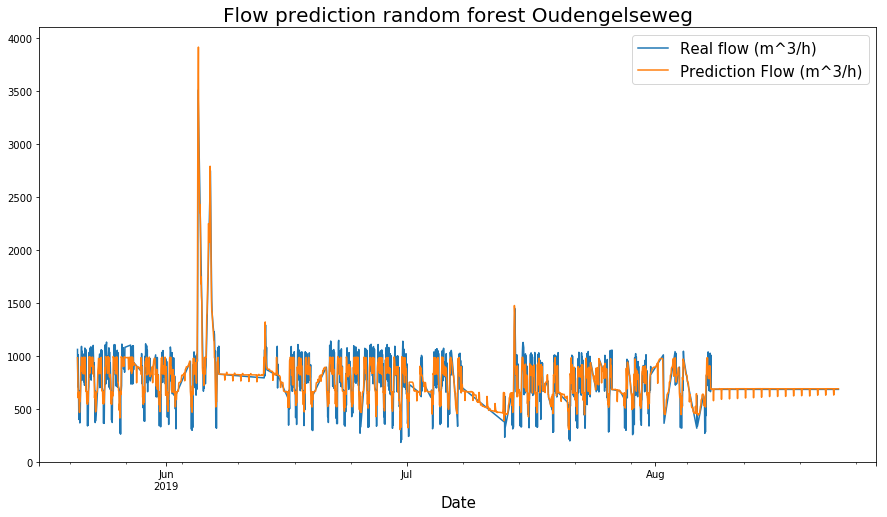

In [45]:
visualize(oudengelseweg, 'Oudengelseweg')

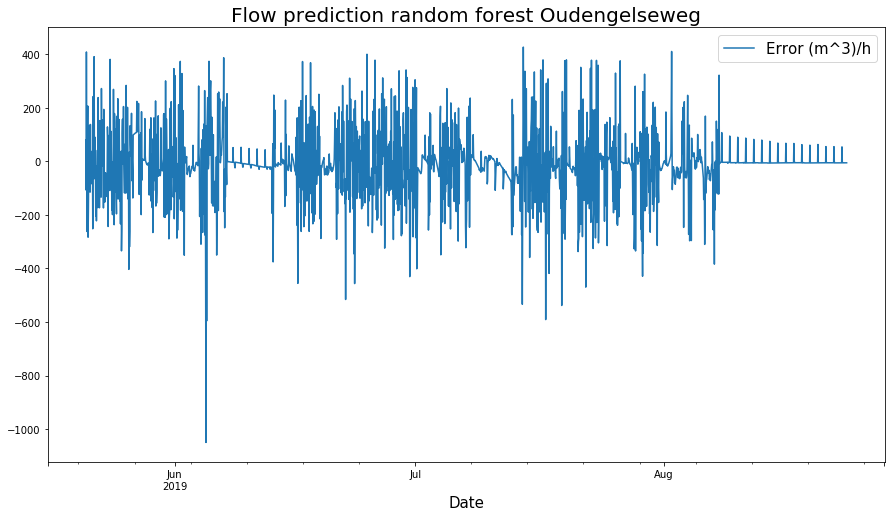

In [46]:
visualize_mse(oudengelseweg, 'Oudengelseweg')

In [47]:
mse(oudengelseweg)

121.22558620912797

In [48]:
mae(oudengelseweg)

76.23181720092927

### Old model

In [22]:
def RF_model(data, name):
    X = (data.drop([name], axis = 1))
    y = (data[name])
    
    X_train = pd.DataFrame(X.iloc[:round(0.99*len(X)),:])
    y_train = pd.DataFrame(y.iloc[:round(0.99*len(y))])
    y_predicted = pd.Series()
    y_real = pd.Series()
    
    n_train = round(0.99*len(X))
    n_records = len(X)
    print('Starting point: ', n_train)
    print('Finish: ', n_records)
    for i in range(n_train, n_records):
        X_train, X_test = X.iloc[0:i,:] , X.iloc[i + 1:i + 24,:]
        y_train, y_test = y[0:i], y[i + 1: i + 24]
        if i % 100 == 0:
            print(i)
        
        RF_Model = RandomForestRegressor(n_estimators=50, random_state = 42, oob_score=True, max_depth = 6)
        
        rgr = RF_Model.fit(X_train, y_train)

        y_real = y_real.append(pd.Series(y_test, index = y_test.index))
        
        predicted = rgr.predict(X_test)
        print(predicted)
        y_predicted = y_predicted.append(pd.Series(predicted, index = X_test.index))        
        
    validation = pd.DataFrame(index = y_real.index)
    validation['Real flow (m^3/h)'] = y_real
    validation['Prediction Flow (m^3/h)'] = y_predicted
    
    return validation